Data loaded successfully.
Starting preprocessing...
Data shape after preprocessing: (2919, 230)
Starting model training...
--- Fold 1 ---
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1

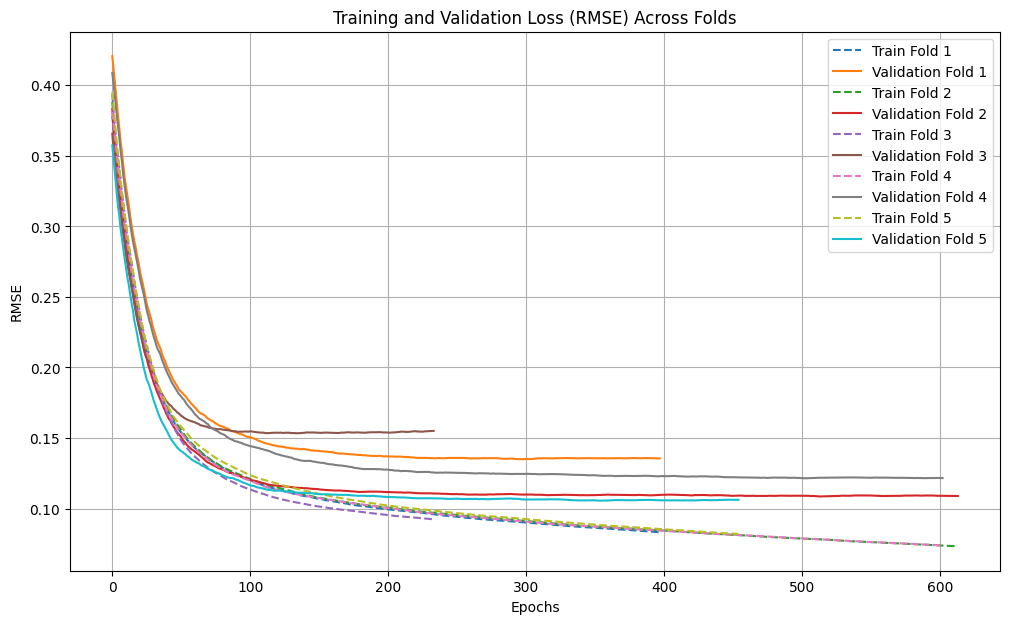


--- Model Evaluation ---
Average Cross-Validation RMSE: 0.1248
This is the expected RMSE on the log-transformed SalePrice.
--------------------------
Model training complete.
Submission file 'submission.csv' created successfully.
     Id      SalePrice
0  1461  123101.564496
1  1462  156497.976112
2  1463  183488.048278
3  1464  190682.047582
4  1465  190858.906086


In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Data Loading and Initial Preparation ---
def load_data():
    """Loads the training and testing datasets."""
    try:
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        print("Data loaded successfully.")
        return train_df, test_df
    except FileNotFoundError:
        print("Error: train.csv or test.csv not found.")
        print("Please ensure the data files are in the same directory as the script.")
        return None, None

# --- 2. Preprocessing and Feature Engineering ---
def preprocess(train_df, test_df):
    """Handles missing values, encodes categorical features, and prepares data for modeling."""
    print("Starting preprocessing...")

    # Store test IDs for submission file
    test_ids = test_df['Id']
    # Drop Id columns as they are not needed for training
    train_df = train_df.drop('Id', axis=1)
    test_df = test_df.drop('Id', axis=1)

    # Log transform the target variable 'SalePrice' to handle skewed data
    train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

    # Combine train and test data for consistent preprocessing
    all_data = pd.concat((train_df.loc[:,'MSSubClass':'SaleCondition'],
                          test_df.loc[:,'MSSubClass':'SaleCondition']))

    # --- Handle Missing Values ---
    # For many categorical features, 'NA' has a specific meaning (e.g., no alley, no pool).
    # We will fill these with 'None' or 0 based on the data description.
    for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
                'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
        all_data[col] = all_data[col].fillna('None')

    # For numerical features, we'll fill with 0 or the median.
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        all_data[col] = all_data[col].fillna(0)

    # For the rest, use the mode (most frequent value) of the column.
    all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    all_data['Utilities'] = all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])
    all_data['Functional'] = all_data['Functional'].fillna(all_data['Functional'].mode()[0])
    all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
    all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
    all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
    all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
    all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

    # LotFrontage: Fill with the median of the neighborhood
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))

    # --- Feature Engineering ---
    # Combine some features to create new ones
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
    all_data['Total_Bathrooms'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] +
                                   all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])
    all_data['Total_Porch_SF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                                  all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                                  all_data['WoodDeckSF'])
    # Simplified quality metrics
    all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


    # --- Label Encoding for Categorical Features ---
    # Convert categorical variables into numerical representations.
    # Using pandas get_dummies is another good option.
    cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
            'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
            'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
            'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
            'YrSold', 'MoSold')

    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(all_data[c].values))
        all_data[c] = lbl.transform(list(all_data[c].values))

    # One-hot encode remaining categorical features
    all_data = pd.get_dummies(all_data)

    print(f"Data shape after preprocessing: {all_data.shape}")

    # Split back into training and testing sets
    X = all_data[:len(train_df)]
    X_test = all_data[len(train_df):]
    y = train_df['SalePrice']

    return X, y, X_test, test_ids

# --- 3. Model Training and Prediction ---
def train_and_predict(X, y, X_test):
    """Trains a LightGBM model and makes predictions."""
    print("Starting model training...")

    # Using K-Fold cross-validation to make the model more robust
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    predictions = np.zeros(X_test.shape[0])
    models = []
    rmse_scores = [] # To store RMSE of each fold
    history = {'train': [], 'val': []} # To store training history

    plt.figure(figsize=(12, 7)) # Initialize the plot

    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"--- Fold {fold+1} ---")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # LightGBM Model parameters
        lgb_model = lgb.LGBMRegressor(objective='regression',
                                      num_leaves=5,
                                      learning_rate=0.05,
                                      n_estimators=720,
                                      max_bin=55, bagging_fraction=0.8,
                                      bagging_freq=5, feature_fraction=0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf=6,
                                      min_sum_hessian_in_leaf=11,
                                      random_state=42)

        lgb_model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_val, y_val)],
                      eval_metric='rmse',
                      callbacks=[lgb.early_stopping(100, verbose=False)])

        # --- Store and Plot History ---
        evals_result = lgb_model.evals_result_
        train_loss = evals_result['training']['rmse']
        val_loss = evals_result['valid_1']['rmse']
        
        plt.plot(train_loss, label=f'Train Fold {fold+1}', linestyle='--')
        plt.plot(val_loss, label=f'Validation Fold {fold+1}')


        # Evaluate the model on the validation data for this fold
        val_preds = lgb_model.predict(X_val)
        fold_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        rmse_scores.append(fold_rmse)
        print(f"Fold {fold+1} RMSE: {fold_rmse}")

        # Predict on the test set
        fold_preds = lgb_model.predict(X_test)
        predictions += fold_preds / kf.n_splits
        models.append(lgb_model)
    
    # --- Finalize and Show Plot ---
    plt.title('Training and Validation Loss (RMSE) Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Accuracy Evaluation ---
    mean_rmse = np.mean(rmse_scores)
    print("\n--- Model Evaluation ---")
    print(f"Average Cross-Validation RMSE: {mean_rmse:.4f}")
    print("This is the expected RMSE on the log-transformed SalePrice.")
    print("--------------------------")


    print("Model training complete.")
    return predictions

# --- 4. Create Submission File ---
def create_submission(test_ids, predictions):
    """Creates the submission file in the required format."""
    # Reverse the log transformation to get the actual sale prices
    final_predictions = np.expm1(predictions)

    submission = pd.DataFrame({
        "Id": test_ids,
        "SalePrice": final_predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("Submission file 'submission.csv' created successfully.")
    print(submission.head())


# --- Main Execution ---
if __name__ == '__main__':
    train_df, test_df = load_data()
    if train_df is not None and test_df is not None:
        X, y, X_test, test_ids = preprocess(train_df, test_df)
        predictions = train_and_predict(X, y, X_test)
        create_submission(test_ids, predictions)


